# Basic Autoencoder

This notebook is to train the basic autoencoder model and then perform clustering on the encoder part.

## Imports

In [2]:
!pip install "torch==1.4" "torchvision==0.5.0"

     |████████████████████████████████| 753.4MB 23kB/s 
     |████████████████████████████████| 4.0MB 40.2MB/s 
  Found existing installation: torch 1.5.0+cu101
    Uninstalling torch-1.5.0+cu101:
      Successfully uninstalled torch-1.5.0+cu101
  Found existing installation: torchvision 0.6.0+cu101
    Uninstalling torchvision-0.6.0+cu101:
      Successfully uninstalled torchvision-0.6.0+cu101


In [0]:
from fastai import *
import torch
from torch import nn
import imageio
from fastai.vision import *
import os
import torch.nn.functional as F
import numpy as np
from automatic_asset_classification import baseline_model
from automatic_asset_classification import model_layers

In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount = False)
%cd "/content/drive/My Drive/automatic-asset-classification"
%ls

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/automatic-asset-classification
ae_res_1_new    ae_res_3_torch  ae_res_5_torch       final_model  test.png
ae_res_1_torch  ae_res_4_new    ae_res_6_new         model1.pt
ae_res_2_new    ae_res_4-new    ae_res_6_torch       model2.pt
ae_res_2_torch  ae_res_4_torch  basic_animation.mp4  models/
ae_res_3_new    ae_res_5_new    data/                outputs/


## Data Import

Data is imported using a fastai ImageImageList. This allows both an input and output to be an image.

In [5]:
np.random.seed(3333)
torch.manual_seed(3333)
image_path = "data/final_dataset"
size = 224
batchsize = 32

tfms = get_transforms(do_flip = True)
src = (ImageImageList.from_folder(image_path).split_by_rand_pct().label_from_func(lambda x: x))
data = (src.transform(tfms, size=size, tfm_y=True)
        .databunch(bs=batchsize)
        .normalize(imagenet_stats, do_y = False))
print("imported")

imported


In [0]:
data

ImageDataBunch;

Train: LabelList (444 items)
x: ImageImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
Path: data/final_dataset;

Valid: LabelList (110 items)
x: ImageImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
Path: data/final_dataset;

Test: None

## Training

### Initiate the model

In [0]:
autoencoder=baseline_model.Autoencoder()
learn = Learner(data, autoencoder, loss_func = F.mse_loss)

### Training

In [0]:
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,time
0,0.254107,0.245377,00:22
1,0.240359,0.217608,00:21
2,0.229178,0.196285,00:21
3,0.217968,0.186721,00:21
4,0.209734,0.186338,00:21


In [0]:
learn.lr_find()

epoch,train_loss,valid_loss,time
0,0.190214,#na#,00:17
1,0.189308,#na#,00:15
2,0.189111,#na#,00:16
3,0.189733,#na#,00:15
4,0.187190,#na#,00:16
5,0.168194,#na#,00:15
6,0.168733,#na#,00:15


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 5.75E-02
Min loss divided by 10: 5.25E-02


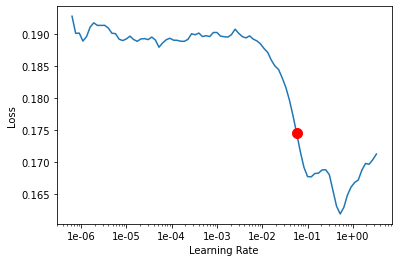

In [0]:
learn.recorder.plot(suggestion=True)

In [0]:
learn.fit_one_cycle(10, max_lr=1e-02)

epoch,train_loss,valid_loss,time
0,0.185977,0.176591,00:21
1,0.175457,0.188192,00:22
2,0.146708,0.068057,00:21
3,0.112545,0.062135,00:21
4,0.090920,0.039983,00:21
5,0.076032,0.035699,00:21
6,0.065506,0.035070,00:21
7,0.057706,0.033419,00:21
8,0.052093,0.033211,00:21
9,0.047951,0.033024,00:20


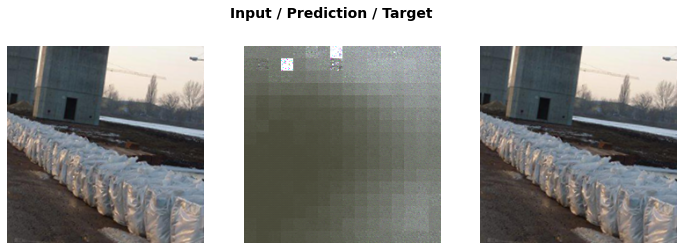

In [0]:
learn.show_results(ds_type=DatasetType.Train,rows=1)

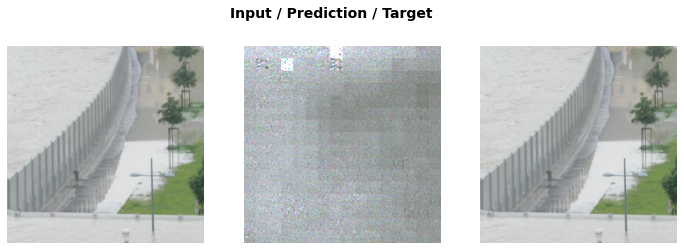

In [0]:
learn.show_results(ds_type=DatasetType.Valid,rows=1)

### Save the model

In [0]:
torch.save(learn.model, "model1.pt")

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type autoencoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type encoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type convblock. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type downsamp. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python

## Clustering

### Create an encoder model

In [0]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        #Load the trained model and keep the encoder part
        self.encoder = torch.load("model1.pt").encoder
        
    def encode(self,x): return self.encoder(x)
            
    def forward(self, x):
        encoded = self.encoder(x)
        return encoded

In [0]:
ec = Encoder1()
enc1=Learner(data, ec,loss_func=F.mse_loss)

In [17]:
preds,acts=enc1.get_preds()

Convert the prediction of the validation set into a numpy array.

In [0]:
cluster_data = preds.numpy()

Standardise the data ready for the PCA.

In [0]:
cluster_data_std = (cluster_data - cluster_data.mean())/cluster_data.std()

In [0]:
from sklearn.decomposition import PCA
pca = PCA(n_components=50)
cluster_data_pca = pca.fit_transform(cluster_data_std)

Find optimal number of clusters

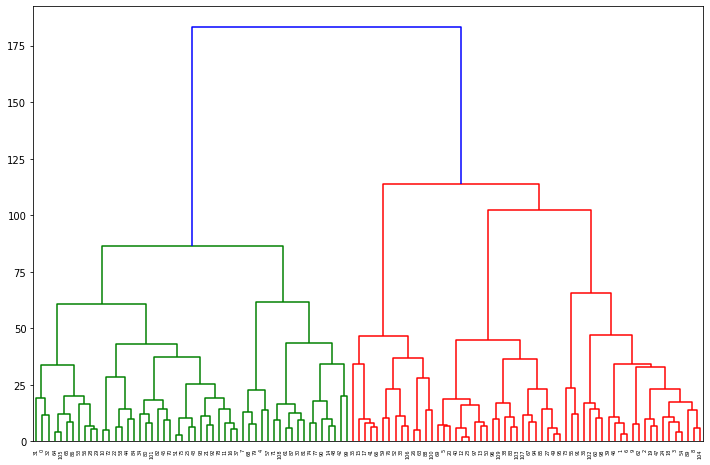

In [25]:
linked = linkage(cluster_data_pca, method = 'ward')
fig = plt.figure(figsize = (12,8))
dendrogram(linked,
            orientation='top',
            #labels=labelList,
            distance_sort='descending',
            show_leaf_counts=True)
plt.show()

Data only splits well into two clusters.

Create a TSNE representation of the encoded data.

In [0]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2, perplexity = 5).fit_transform(cluster_data_pca)
X_embedded2 = TSNE(n_components=2, perplexity = 30).fit_transform(cluster_data_pca)
X_embedded3 = TSNE(n_components=2, perplexity = 50).fit_transform(cluster_data_pca)

In [0]:
from sklearn.cluster import AgglomerativeClustering
cluster = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')
clusters = cluster.fit_predict(cluster_data_pca)

Plot the TSNE representation with clusters coloured:

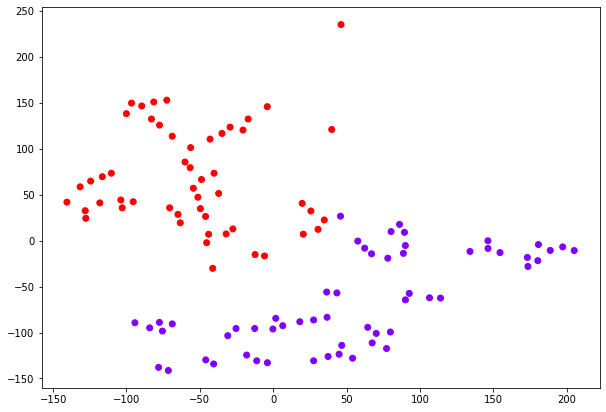

In [47]:
plt.figure(figsize=(10, 7))
plt.scatter(X_embedded[:,0], X_embedded[:,1], c=cluster.labels_, cmap='rainbow')

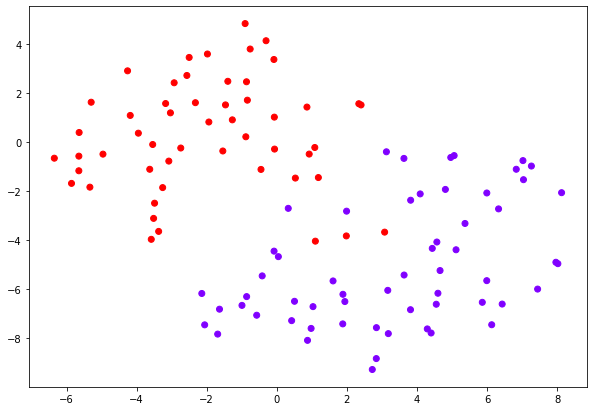

In [48]:
plt.figure(figsize=(10, 7))
plt.scatter(X_embedded2[:,0], X_embedded2[:,1], c=cluster.labels_, cmap='rainbow')

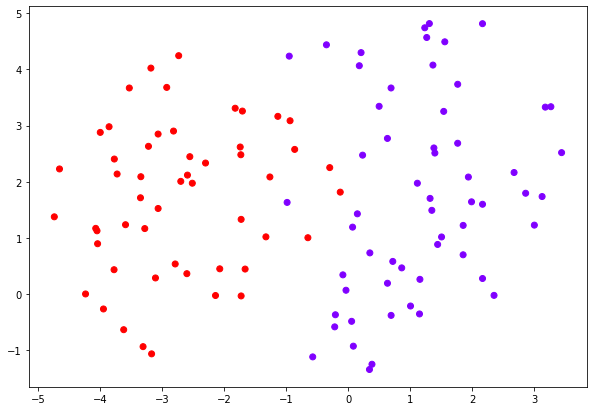

In [49]:
plt.figure(figsize=(10, 7))
plt.scatter(X_embedded3[:,0], X_embedded3[:,1], c=cluster.labels_, cmap='rainbow')

Save the images of each cluster into folders for use:

In [0]:
one_idx = []
two_idx = []

for i in range(len(clusters)):
    if clusters_2[i] == 0:
        one_idx.append(i)
    if clusters_2[i] == 1:
        two_idx.append(i)

In [0]:
for idx in one_idx:
    data.valid_ds[idx][0].save("/content/drive/My Drive/automatic-asset-classification/outputs/basic_autoencoder"
                               "/class1/"+str(idx)+".png")
for idx in two_idx:
    data.valid_ds[idx][0].save("/content/drive/My Drive/automatic-asset-classification/outputs/basic_autoencoder"
                               "/class2/"+str(idx)+".png")